In [1]:
from IPython.display import HTML, display

In [2]:
display(HTML("""<h2>Two Step Forecasting for weather and kWh delivered (using Facebook's Prophet)</h2> <p>In this model, I would be implementing a two-step forecast that would first predict the weather for a time in the future and then use the predicted weather data as an input for the kWh Delivered forecasting for the model</p>"""))

In [3]:
# Install Facebook's Prophet

In [5]:
pip install prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 9.0 MB/s eta 0:00:009.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 1.3 MB/s eta 0:00:000:00:01m eta 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 3.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Import necessary dependencies

In [8]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet

In [9]:
# Load an Preprocess the data

In [10]:
# Load and preprocess the data
folder_path = './caltech_weather_data'
data_frames = []

# Function to safely extract data from JSON
def extract_hourly_data(data):
    historical_data = data.get('historical', {})
    for date, details in historical_data.items():
        hourly_data = details.get('hourly', [])
        for hour_data in hourly_data:
            hour_data['date'] = date
            data_frames.append(hour_data)

for file_name in os.listdir(folder_path):
    if file_name.endswith('.json'):
        file_path = os.path.join(folder_path, file_name)
        try:
            with open(file_path) as file:
                data = json.load(file)
                extract_hourly_data(data)
        except (json.JSONDecodeError, KeyError) as e:
            print(f"Error processing file {file_name}: {e}")

df = pd.DataFrame(data_frames)
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

# Select relevant features
features = ['temperature', 'wind_speed', 'pressure', 'humidity', 'precip']
df = df[features + ['date']]

In [ ]:
# Prepare data for Prophet

In [11]:
prophet_dfs = {}
for feature in features:
    prophet_df = df[['date', feature]].rename(columns={'date': 'ds', feature: 'y'})
    prophet_dfs[feature] = prophet_df

# Train Prophet models and make predictions
prophet_models = {}
future_predictions = {}
for feature, prophet_df in prophet_dfs.items():
    model = Prophet()
    model.fit(prophet_df)
    future = model.make_future_dataframe(periods=365)
    forecast = model.predict(future)
    prophet_models[feature] = model
    future_predictions[feature] = forecast[['ds', 'yhat']].rename(columns={'yhat': feature})

# Merge predictions with actual values
results = df[['date']].copy()
for feature in features:
    results = results.merge(future_predictions[feature], left_on='date', right_on='ds', how='left')
    results.drop(columns=['ds'], inplace=True)

10:47:17 - cmdstanpy - INFO - Chain [1] start processing
10:47:20 - cmdstanpy - INFO - Chain [1] done processing
10:47:22 - cmdstanpy - INFO - Chain [1] start processing
10:47:23 - cmdstanpy - INFO - Chain [1] done processing
10:47:24 - cmdstanpy - INFO - Chain [1] start processing
10:47:27 - cmdstanpy - INFO - Chain [1] done processing
10:47:29 - cmdstanpy - INFO - Chain [1] start processing
10:47:30 - cmdstanpy - INFO - Chain [1] done processing
10:47:31 - cmdstanpy - INFO - Chain [1] start processing
10:47:33 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Evaluate the model for each feature and Plot results

Temperature - Mean Absolute Error: 3.9050179441735824
Temperature - Mean Squared Error: 23.214378169604945
Wind_speed - Mean Absolute Error: 3.420776700724999
Wind_speed - Mean Squared Error: 16.96053071045361
Pressure - Mean Absolute Error: 2.363675338562567
Pressure - Mean Squared Error: 9.743366409138954
Humidity - Mean Absolute Error: 15.65423246116273
Humidity - Mean Squared Error: 356.0137158463627
Precip - Mean Absolute Error: 0.09410945843145392
Precip - Mean Squared Error: 0.12982589649058532


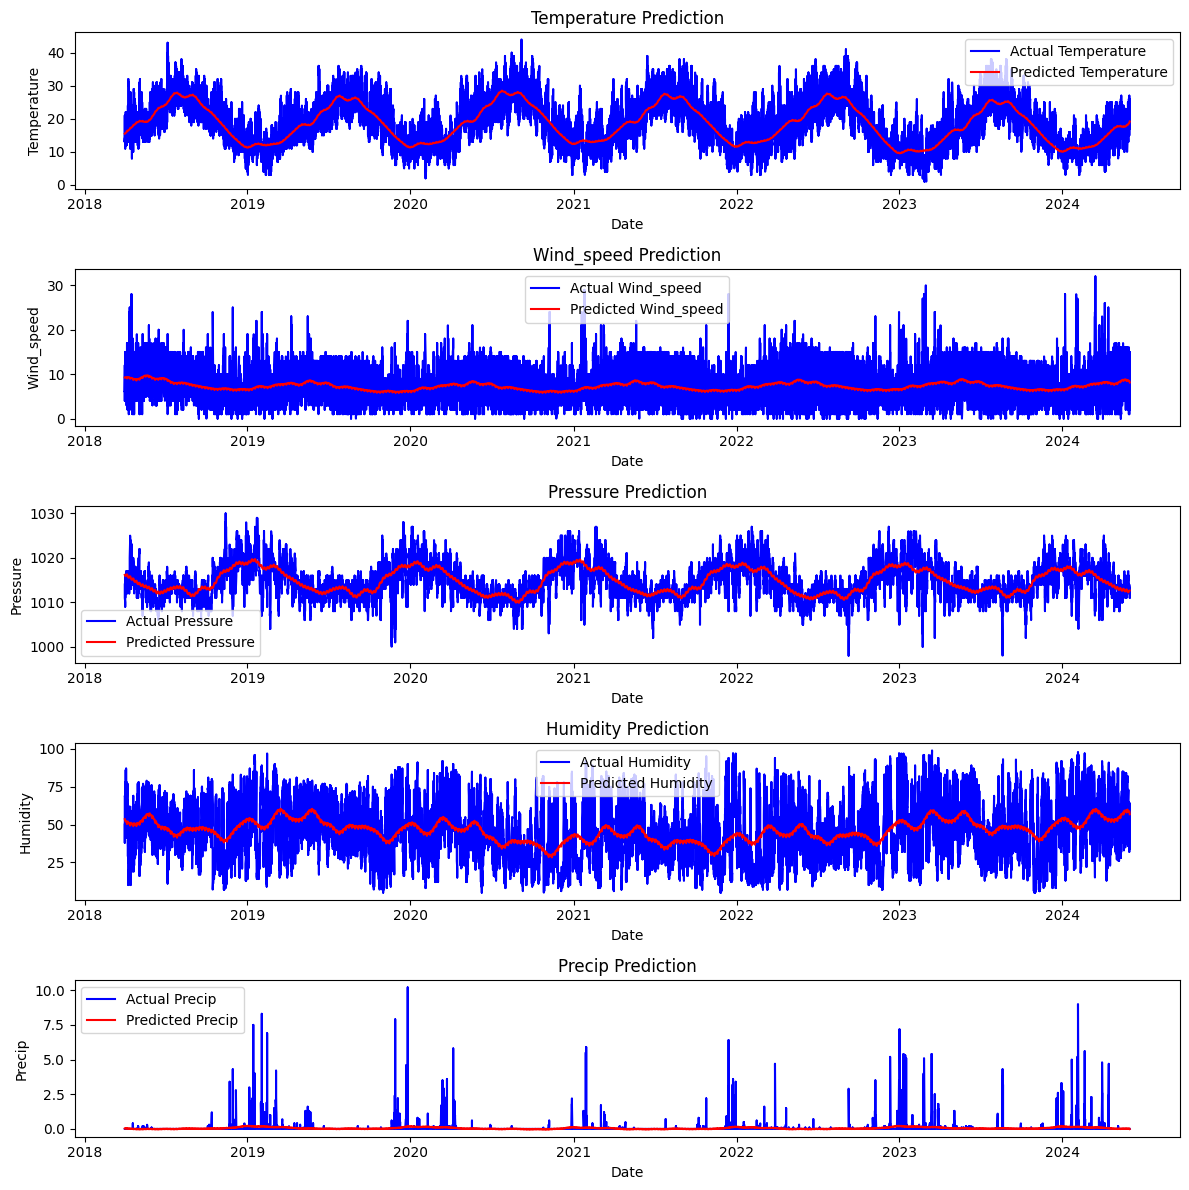

In [12]:
mae_per_feature = []
mse_per_feature = []

for feature in features:
    actual = df[feature].values
    predicted = results[feature].values
    mask = ~np.isnan(predicted)
    actual = actual[mask]
    predicted = predicted[mask]
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    mae_per_feature.append(mae)
    mse_per_feature.append(mse)
    print(f'{feature.capitalize()} - Mean Absolute Error: {mae}')
    print(f'{feature.capitalize()} - Mean Squared Error: {mse}')

# Plot Actual vs Predicted for all features
plt.figure(figsize=(12, 12))
for i, feature in enumerate(features):
    plt.subplot(len(features), 1, i+1)
    plt.plot(df['date'], df[feature], color='blue', label=f'Actual {feature.capitalize()}')
    plt.plot(results['date'], results[feature], color='red', label=f'Predicted {feature.capitalize()}')
    plt.title(f'{feature.capitalize()} Prediction')
    plt.xlabel('Date')
    plt.ylabel(feature.capitalize())
    plt.legend()

plt.tight_layout()
plt.show()